# Practices

In the practical sessions, we will use an opensource simulator ([MUST](https://www.biomecardio.com/MUST/) - Matlab UltraSound Toolbox) to understand how ultrasound images are generated by emitting a forward wave from the transducer, and locating the source of each received echos. The original version of MUST was developed in Matlab by Damien Garcia, but in these sessions we will use a python re-implementation, called pyMUST. The toolbox has the functions to generate B-mode and Doppler images from radiofrequencies, which can be either real or simulated; as well as simulating the acquisition process and generate synthetic radiofrequencies. Here, we will only use simulated data. To simulate the acquisition process, you will have to define the characteristics of the probe and the emitted pulse, as well as the position and reflectivity of the scatterers. Here, we will only use simulated data. Using a simulation has the advantage that it allows to easily change the different parameters of the ultrasound probe, emitted wave in a completely controlled environment and study how it affects image generation. 

The practices are organised as follows, and each consists of a python notebook with a code skeleton and instructions, as well as a document with the questions. Each practice includes a 2h classroom session. After each practice block, you will need to complete the report template, answering the questions, and upload it to the "Campus global".


1. *Radiofrequency (i):* Introduction to MUST, emitted and received signals in a single piezoelectrical element probe, probe bandwidth and center frequency, signal demodulation, attenuation.
2. *Radiofrequency (ii)*: Extension to a setting with probes of several piezoelectrical elements, different emitted waves (linear, circular, focused), time delays in transmission(emission), pressure fields.

3. *B-mode (i)*: Generate a grayscale image from the radiofrequency: beamforming using Delay-And-Sum matrix, log-compression, image resolution.
4. *B-mode (ii): Reconstruction in a polar grid, in-depth view on the Delay-and-Sum matrix, convex array.

5. *Doppler (i):* Measure velocities of few scatterers using spectral and color (phase) Doppler. 
6. *Doppler (ii):* Measure velocities in a 2D geometry, using a synthetic rotating disk, display the velocity field as a color map in an image (color Doppler).


Instructions for the practice: 
- You have to work in groups of 2-3
- Read the practice instructions and explanations. Exercises will require you to complete code, change parameters and/or comment the results.
- REMEMBER TO ADD ALL REFERENCES AND CORRECTLY QUOTE ANY RESOURCE YOU USE. VERBATIM QUOTING MUST HAVE QUOTATION MARKS ("") AND FULL REFERENCE.
- Any attempt of cheating (copying from others, copying from internet, etc.) will result in a 0 grade for the whole course and disciplinary action.
- At the end, upload the report in the "Aula global". There are separated deliverables for the written report and the python code.
- Be brief in the report. Most questions are answered in a single sentence.

Hints for the code:
- Most of the parts that you need to complete are just a few lines.
- When you need to test many parameters, you can copy paste a cell several times, or use a for loop, so you don't lose previous progress.
- Look at the example notebooks in PyMUST! They are a python version of the same notebooks available for the Matlab version, and contain examples of most of the code that you need to complete the exercises. Note: copy-pasting code from the examples will NOT be considered plagiarism, <strong>as long as there is a comment specifying the exact source (file and cell number)</strong>.

# About MUST
MUST (Matlab UltraSound Toolbox) is an open source source to process ultrasound signals, as well as simulate. It was originally developed by Damien Garcia, an INSERM researcher at the CREATIS lab in Lyon, France. The toolbox is based on the theory of linear scattering and Huygens principle, that states that each scatterer emits a spherical wave when stimulated by an incoming wave. In this seminars, we will use a Python translation of that toolbox, developed for the SIB subject at UPF. It is still under development, so not all functionalities are available yet and there might be some bugs. As of January 2024, it is possible to install it via pip, or as a conda package. You can find the source code in the github page (https://github.com/creatis-ULTIM/PyMUST).

The MATLAB documentation is more comprehensive than the Python one, but keep in mind that python does not allow a variable number of return values, so it is assumed that it will always return the maximum number of arguments. You can find plenty of examples in the manual, and the webpage (https://www.biomecardio.com/MUST).

If you find any bug, different behaviour/results between the Matlab and Python versions, or bad performance, please report it in the github page, or send an email to the maintainers (gabriel.bernardino@upf.edu, damien.garcia@creatis.insa-lyon.fr).

## Installation

You can install pymust from in the conda package manager.

### Other ways of installation

The second easiest is to install using pip. Run the following command in a terminal:

```bash
pip install pymust
```

Or in a notebook cell:

```python
!pip install pymust
```

If this does not work, you can copy the source code from the github repository, and install it locally.

# Practice 1

The first laboratory will serve as an introduction to pymust, to familiarize with the ultrasound simulatior environment and their main components. We will work mostly with the emitted and received radiofrequency signals, in a single-element probe and see the different probe parameters (bandwidth and central frequency) influence the procedure. We will also explore the receive signal, which includes the echos generated by scatterers and see the influence of attenuation of the medium.

In [2]:
import pymust, pymust.utils, numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
def to_dB(X):
    """
    Convert a signal to dB
    """
    if np.min(X) < 0:
        raise ValueError('Cannot convert negative values to dB')
    return 10 * np.log10(X/np.max(X) + 1e-10)

def my_ifft(X, df, one_sided = True):
    """
    @param X: The signal to be transformed
    @param df: The sampling frequency of the signal
    @param one_sided: Whether the signal is one-sided (in which case it is assumed to be conjugate symmetric) or not
    """
    if not one_sided:
        n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat =  np.fft.fftshift(np.fft.ifft(X, n))
        t = np.linspace(0, 1/df, n)
    else:
        n = 2**pymust.utils.nextpow2(X.shape[-1] - 1) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat = np.fft.fftshift(np.fft.irfft(X, n))
        t = np.linspace(0, 1/df, n)

    return t, X_hat

def trim_function(t, X):
    """ Remove the region of the signal that is almost 0"""
    X_max = np.abs(X).max()
    i = np.where(np.abs(X) > X_max * 1e-3)
    idx = np.arange(i[0][0], i[0][-1])
    t -= t[idx[0]]
    return t[idx], X[idx]


def my_fft(X, dt, one_sided = True):
    n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
    if not one_sided:
        X_hat =  np.fft.fft(X, n)
        f = np.fft.fftfreq(n, dt)
    else:
        X_hat = np.fft.rfft(X, n)
        f = np.fft.rfftfreq(n, dt)

    return f, X_hat

# Utilities

#If at some point you get a warning that you have too many figures open, you can use this function to close them all
def closeAllFigures():
    plt.close('all')

"""
You don't need to use the following functions, they are just if you are curious and  want to inspect the code
"""
import inspect
def getSourceCode(s):
    """
    This function will allow to inspect the source code of a function (as a string).  Use this function if you want to see the code of a function, but don't know where it has been installed.
    For instance, if you want to access the source code of the function pymust.rf2iq, you can do:
    ''getSourceCode(pymust.rf2iq)''
    """
    return inspect.getsource(s)

def getModulePath(m):
    """
    This returns the path to a module, so you can search it in the file system. For instance, you can see where numpy is installed by using:
    ''print(getModulePath(np))''
    """
    return m.__file__

## Part 1:  Emitted signal

On the first part we will work on the emitted signal by the transducer.

The first step is to define the ultrasound probe, which is stored in a "param" struct. In the next sessions, param will include as well as information of the media parameters (speed of sound, attenuation) that will be needed for the simulation. This struct will be given as parameters to most MUST functions. During the first session, our transducer will have a single piezoelectrical element, and it is already defined up for you below. This struct behaves like a python dictionary, but you can also access or set parameters using the point notation.

We will generate the signal emitted by the transducer. The transducer is composed of many piezoelectrical elements, that when excited with an electrical current, will generate a pressure wave. This signals will be reflected back when they hit a scatterer, and will be recorded by the piezoelectrical element (which transform pressure waves to electrical signals when are in reading mode). The emitted signal is centered around a central frequency (fc), which is the natural vibration frequency of the element (quartz). If we only emit this frequency, this would be a pure tone which is infinite in time, but to detect objects we are interested in emitting a pulse that will give us better spatial resolution[^1], there will be a certain bandwidth of frequencies involved. This bandwidth is expressed as a percentage of the central frequency, and has to be between 0 and 200. Therefore, the frequency band of the probe goes from $fc*(1 - bw/2/100)$ to $fc**(1 + bw/2/100)$. The first exercise is to understand how these parameters affect the emitted signal, and understand basic concepts of ultrasound signal processing.


 [^1]: except when doing continuous Doppler, where a single frequency signal is emitted.

In [4]:
def getProbe():
    """
    Gets a probe that has a single piezoelectrical element
    """
    ## Define the probe (an empty one)
    param_single_element = pymust.utils.Param()

    #For now, you must focus in these two parameters: center frequency and bandwidth
    param_single_element.fc = 2.7e6
    param_single_element.bandwidth = 76 

    # This sets a single piezoelectrical element
    param_single_element.Nelements = 1

    # You will not need to use these parameters until S4, they define the geoemtry of the probe
    param_single_element.radius = np.inf
    param_single_element.kerf = 3e-05
    param_single_element.width = 0.00027
    param_single_element.pitch = 0.0003
    param_single_element.height = 0.005
    
    return param_single_element

In [5]:
param_single_element = getProbe()
param_single_element # use this to visualise the fields defined in the param_single_element struct

{'fc': 2700000.0,
 'bandwidth': 76,
 'Nelements': 1,
 'radius': inf,
 'kerf': 3e-05,
 'width': 0.00027,
 'pitch': 0.0003,
 'height': 0.005}

We will an in-depth look at the pulse and probe functions, which are defined in the frequency domain. The pulse function is an "idealised pulse", that we would like to emit. If you look at its definition (pymust/utils.py, getPulseSpectrumFunction), you will find that it is the combination of two cardinal sinus, one centered at +fc, and the other at the negative -fc. This comes from convoluting a step function, with a sinus with frequency fc. However, devices will not be able to emit such signals, since they have a limited bandwidth which they can emit. These limitations are represented by the probe function, which acts as a filter. This function depends basically on the bandwidth parameter, and is a bandpass filter with a bandwidth [in frequency] equal to fc * bw/100. There are several ways of measuring the bandwidth of a signal, since most of them are never exactly 0. We will use the -3dB bandwidth, which is the length of the interval where the signal is above -3dB of its maximum power. You can use the function to_dB to transform to decibels (remember to take the absolute value if it is a complex signal). 

*Note*: you will be asked to convert from the frequency to time domain, and viceversa using the Fourier transform. You have some functions above defined so you can use them.

## Code to complete
The following code a multiview plot. Some of the plots are already done for you as examples, the others you have to complete, based on their title. 

If all your calculations are correct, the two plots below, showing the emitted signal in the time domain, should be almost the same.

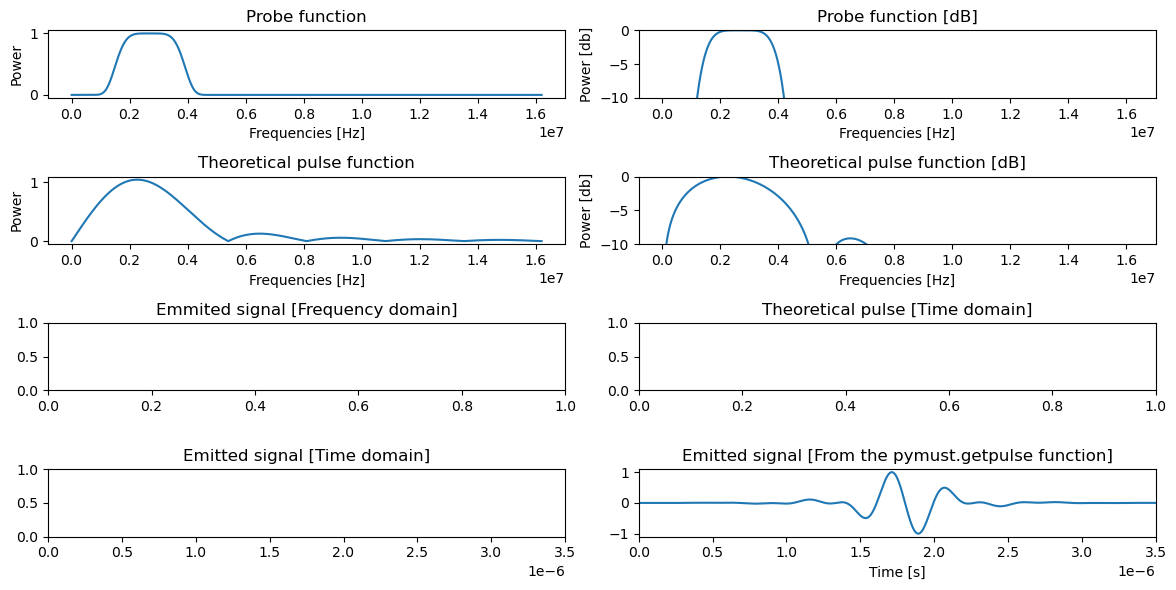

In [6]:
# This are the parameters that you will need to modify
param_single_element.TXnow = 1 # To emit several pulses
param_single_element.fc = 2.7e6
param_single_element.bandwidth = 76  # The bandwidth is expressed as a percentage of the central frequency, and can go from 0 to 200 (values greater than 200 would reach the 0 frequency)



freqs = np.linspace(0,  6 * param_single_element.fc, 10000) #Plot only the spectrum between 0 and 3 times the central frequency
df = freqs[1] - freqs[0]
ws = 2* np.pi * freqs # The probe and actually work with angular  frequencies

probeFunction = param_single_element.getProbeFunction() # A function call that returns a function. This is allowed in Python
pulseFunction = param_single_element.getPulseSpectrumFunction() 


_, fs = plt.subplots(ncols = 2, nrows = 4, figsize =(12, 6)) 


# Probe function

plt.sca(fs[0,0]) # Plot in the first figure of the grid
plt.plot(freqs, probeFunction(ws))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')
plt.title('Probe function')


plt.sca(fs[0,1]) 
plt.plot(freqs, to_dB(np.abs(probeFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.title('Probe function [dB]')
plt.ylim(-10, 0)

# Pulse function

plt.sca(fs[1,0]) 
plt.plot(freqs, np.abs(pulseFunction(ws)))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')
plt.title('Theoretical pulse function')

plt.sca(fs[1,1]) 
plt.plot(freqs, to_dB(np.abs(pulseFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.title('Theoretical pulse function [dB]')
plt.ylim(-10, 0)


# Emmited pulse  - Your computation
# Do the convolution of the probe and pulse functions in the frequency domain, 
emmited_pulse_freq = ...

plt.sca(fs[2, 0]) 
# EXERCISE: Here you should plot the emmited pulse in the frequency domain, which is the time domain convolution of the probe and pulse functions - to which operation it corresponds in the frequency domain?
plt.title('Emmited signal [Frequency domain]')

plt.sca(fs[2, 1]) 
# EXERCISE: Use the inverse Fourier transform to transform the theoretical emmited pulse from the frequency domain  to the time domain
# Note: the theoretical pulse might not be very well centered, you can use the trim_function to remove the region of the function that is almost 0

plt.title('Theoretical pulse [Time domain]')




plt.sca(fs[3, 0]) 
# EXERCISE: Transform the emmited pulse from the frequency domain  to the time domain using the inverse Fourier transform
# Note: the emmited pulse might not be very well centered, you can use the trim_function to remove the region of the function that is almost 0
plt.title('Emitted signal [Time domain]')
plt.xlim([0, 3.5e-6])

#plt.xlim([2.2, 2.6])

plt.sca(fs[3, 1]) 
# Here is the emmited pulse in ftime domain, as computed directly in pymust. The result should be the same as in the previous plot
# Emmited pulse  - From pymust
pulse, t = pymust.getpulse(param_single_element, way = 1)
pulse = pulse[::-1]


plt.plot(t, pulse)
plt.xlabel('Time [s]')
plt.title('Emitted signal [From the pymust.getpulse function]')
plt.xlim([0, 3.5e-6])

plt.tight_layout()

if not os.path.isdir('Figures'):
    os.mkdir('Figures')
plt.savefig('Figures/s1_ex1.png')

Answer these questions regarding the first part of the session. Include in the report the figure obtained after completing the code. Here we will look at the emitted pulse, which is the time-domain convolution of the emitted pulse, and the probe function. The probe function is a bandpass filter, and represents the frequency range that the probe can physically emit, is  which is defined in the frequency domain. The emitted pulse is the convolution of the probe function and the pulse function.

### Exercise 1.1: Emitted pulse
1. To obtain the emitted pulse, you have to multiply the spectras of the probe and theoretical pulse functions. To what operation does it correspond in the time domain? Transform the result to the time domain using the ifft. 

1. Complete the code in the cell above (the one of the multiplots), and include it in your report. Focus on the emitted signal in the time domain. Describe its shape and duration, when compared to the theoretical pulse (also in the time domain).

1. Qualitatively compare the width of the spectra of the theoretical and emitted pulses, and of their duration in the time domain, and the width of both of their Fourier spectra. From your knowledge on signals and systems, argue why this happens.

1. [Extra] The theoretical pulse is the combination of two cardinal sinus (sinc) on the pulse spectrum, one centered at +$f_c$, and the other one at -$f_c$. Why are two cardinal sinus needed? Note: you can obtain a single spectrum of a single sinc, and explain what happens when you apply the Fourier transform. 

1. [Extra] Compute the frequency with the maximum power of the emitted pulse. Compare it to the central frequency of the probe. What do you observe? Hint: you can check what is the central frequency of a single cardinal sinus, and the effect of the second cardinal sinus on the main lobe of the first.



## Part 2: Probe parameters

Real commercial ultrasonic transducer for medical typically offer a black-box solution for emission and image reconstruction, and only allow the operator to vary few of the parameters, mostly related to the acquisition settings. This makes them easier to use, but it is not possible to obtain the raw received radiofrequency signal, or emit custom sequences. On the other side, research transducers allow controlling all its emission parameters from a computer, and save its received radiofrequency signal to a computer. In this seminar, we will use a computer-based simulator to emulate a research setting, and obtain a synthetic received signal which we can process ourselves to learn of the . We will focus on the received signal, which is obtained via the "simus" function. This function requires the following parameters:
- Definition of the probe: including bandwidth and central frequency of the probe, as in the previous section.
- Activation delay (also known as transmit delay - txdelay) for each piezolectrical element of the probe (in this case is simply a vector with a single 0, since there is a single element in the transducer, but it will be explored in next exercise).
- Positions and reflecting coefficients of the point scatterers (i.e. points in the tissue / blood that reflect part of the signal, and are what generates the image). In a real setting, this would be unknown and what we would like to examine in the image. 

In this exercise, you will modify two parameters: the bandwidth (range of frequencies that can be emitted by the probe), and the central frequency, which is the main frequency of the signals, and correspond to the natural vibrating frequency of the quartz piezoelectrical element. 

To know more on the probe characteristics, you can visit (https://verasonics.com/verasonics-transducers/).



### Exercise 1.2: Probe parameters
The objective of this exercise is to understand how the spectra of the emitted pulse and the probe function affects the characteristics of the emitted pulse. 

*Note:*  Remember that the central frequency and the bandwidth stored in the param struct are characteristics of the probe, and you can change them arbitrary (in reality, you will be limited by the physical transducer you have, but in a simulator you can change it freely). The emitted signal will also have a central frequency, and a bandwidth, which will depend on the characteristics of the probe, but they will not be exactly the same, and will depend as well on other emission settings (for instance, *TXnow* , when you emit a train of pulses ).


1. Compute the bandwidth at -3db (the length of the frequencies above a certain power), and the central frequency (the frequency with more power) of the emitted pulse. Change the bandwidth (bw) and central frequency (fc) of the probe, trying 2 different values of each. Compare the central frequency and bandwidth of the emitted signal with the theoretical values. [Note: theoretical (those that are stored in the *param* variable) and observed (the ones that you will compute) central frequencies will not exactly coincide]

1. Apply the inverse Fourier transform to obtain the time-domain emitted pulse, and qualitatively discuss the influence of the bandwidth on the emitted pulse duration.

1. For some applications, it is beneficial to emit longer pulses, for instance when doing Doppler. For that, we can emit several pulses using the parameter TXnow of the param struct. Change it to 10, and report the effect on the bandwidth and central frequencies of the emitted pulse. Include the plots in your report. 


Hints:
- You can use myfft to do the Fourier transforms
- Beware that some variables are defined in terms of angular moments (ws), and others in frequencies (fs). In order to convert from frequencies to angular moments, you just need to multiply by $2\pi$.
- To compute the bandwidth, you need to count the frequency range above a certain threshold. In order to count the number of a signal above a threshold, you can use the expression np.sum(f > th). In order to get this distance in a physical unit (s, Hz, etc), you need to multiply by the sampling period (1/df) or frequency df.

##### A note on the spatial system of reference

The ultrasound probe is centered at position x = 0, z = 0.

Y coordinates refer to the elevation, and are not used in these tutorials. However, some functions might require to give them a value. In that case, you can use either an array with zeros, or the python empty list []. In most cases, you can also use the python special value *None*.

## Part 3: Received signal

In ultrasound imaging, the emitted pulse interacts with matter. The main interactions are:

- Scatter reflection
- Specular reflection
- Attenuation (absorption)


 Scatter and specular reflections generate echo waves that will go back to the emitter. In this seminars, we will focus on point scatterers, which are small irregularities of approximately the size of the wavelength with high acoustic reflectivity that will produce a spherical wave when hit by the emitted pressure wave. The waves will travel backward, and hit the probe, transmitting part of its mechanical energy to the piezoelectrical element which will generate an electrical signal that is registered. In MUST, specular reflections or second order reflections are not considered. The other type of interaction is attenuation, which is the loss of energy of the wave as it travels through the medium. This is due to the conversion of mechanical energy to heat, and is proportional to the distance traveled by the wave.

 In this section, we will use the simulator in pymust (simus call) to generate the received signal. We need to specify the position of the scatterers, the probe parameters, and the transmit delays (they are only relevant for probes with many elements, we will see them in detail in the next practice)



Remember from theory that when there is a single scatterer at distance $d$ from the probe, if we emmit a signal $e(t)$, then, the recieved signal will $r(t) = e(t - 2\cdot d/c)$, since we will recieve the same signal, just delayed by the time needed for the pressure wave to reach the scatterer, and come back (to be completely accurate, the recieved signal will also be filtered by the probe function, but since it is roughly af band-pass filter, that has been already applied in the emmision, its effect is small).


### Example of simulating an emmited pulse, and recording the echo done in pyMUST using the simus function
Take a look to this code as an example of how to use pymust to simulate an acquisition:

Text(0.5, 0, 'Time [s]')

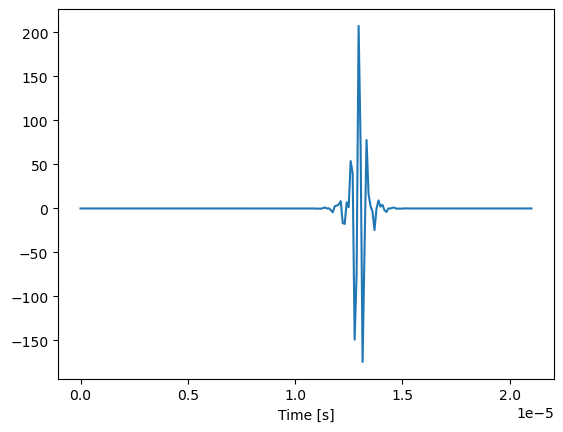

In [10]:
# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param_single_element.c = 1540

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_single_element)
fs = param_single_element.fs # Sampling frequency
t = np.arange(RF.shape[0]) / fs # Time vector
nSamples = RF.shape[0] 

# RF is a matrix, since in most interesting cases, we will have a channel for each element of the transducer array, but here we will only have one element
# Plot the signal
plt.plot(t, RF[:,0])
plt.xlabel('Time [s]')

### Part 3 Received wave - delay and distance

Here we will see the effect of the distance from the scatterer to the probe, in terms of the received radiofrequency signal. We will investigate this in the presence of attenuation, which accounts for the energy loss of the signal when it traverses the media. 

A code is given, that you'll need to complete, by  adding the Fourier transform of the signal. This code displays the signal for several scatterers at different positions from the probe.

Finally, you will use the tgc function, which receives a RF vector, and returns, as a first parameter, the signal after applying time-gain-compensation (it estimates the loss in energy, assuming an exponential model in time, as a signal that travels longer has been more attenuated), and as a second parameter the information on the estimated exponential.

In [8]:
# There is always a first scatterer close to the transducer to fix the scale.
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param_single_element.c = 1540

_, fs = plt.subplots(ncols = 5, nrows = 2, figsize = (20, 5))

distances = np.linspace(1e-2, 1e-1, num = 5)
for idx, f in np.ndenumerate(fs):
    i,j = idx[0], idx[1]
    if  i == 1:
        continue
    # Change the  scatterer only
    zScatterers[0] = distances[j]
    
    RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_single_element)
    t = np.arange(RF.shape[0]) / param_single_element.fs  # param_single_element.fs is the sampling frequency, needed to go from sample number to time

    #TODO: compute the spectra of the radiofrequency using the Fourier transform. You can use my_fft defined above
    f, RF_spectrum =  ...
    #print(f.shape)
    # Plot the signal
    plt.sca(fs[i,j])
    plt.plot(t, RF[:, 0])
    plt.xlabel('Time [s]')
    plt.ylabel('Received signal')
    plt.title('Distance = {:.2f} cm'.format(distances[j]*100))
    
    # If not done anything, each of these plot will have its own scale on the x and y axis. You can control this with xlim and ylim 

    #TODO: uncomment the following line to set the range of the plots to be equal in all subplots. 
    # You have to give an appropriate value so that all plots have the same scale in the x and y axis() Hint: you can use a hardcoded value)
    # plt.xlim(0, tMax)
    # plt.ylim (-vMax, vMax)

    # Plot the spectra
    plt.sca(fs[i + 1,j])
    plt.tight_layout()
    plt.plot(f, np.abs(RF_spectrum))
    plt.xlabel('Frequency [Hz]')
    plt.xlim(0, 3* param_single_element.fc)
plt.savefig('Figures/s1_ex3.png')

NameError: name 'param_single_element' is not defined

### Exercise 1.3

1. For each distance configuration, compute the approximate time delay between emission (at 0s) and the time at which the sample with maximal power is received. What is the relation of the receiving time of the reflected pulse reemitted by an scatter, and the distance to the scatterer? [Hint: to compute the index of the maximum element in an array, you can use np.argmax]

1. Complete the previous code to plot the frequency domain of the received signal for each distance (line 24). Without attenuation, what do you observe with the shape of the frequency, when compared to the emitted signal in the previous exercises? [Include the plot]

## Part 4: Several scatterers

Now we will use the *simus* function with several scatterers, and study the received signal, which now will be composed of several pulses. This scatterers do not necessarily be aligned, and can have arbitrary positions in the space. As we only have a single piezoelectrical element, the only element that we will be able to discriminate from each scatterer is its distance to the probe. 

We will have an informal impression of the *axial resolution* concept, which is the minimal separation between two scatterers so that we can distinguish their reflected pulses. As you will see, this is related on the pulse sharpness, and therefore in the bandwidth and central frequency of the probe.

In [19]:
param_single_element = getProbe()
param_single_element.attenuation = 0.
#param_single_element.bandwidth = 10 # Modify to reduce the bandwidth of the probeI

In [14]:
xScatterers = np.array([0, 0,np.sqrt(2)*1e-2, - np.sqrt(2)*1e-2,  0])
zScatterers = np.array([1e-2, 2e-2, np.sqrt(2) * 1e-2, np.sqrt(2) * 1e-2, 2.2e-2])
RCScatterers = np.random.rand(5) # There are 5 scatterers
#RCScatterers[1:] = 0
activationDelaysTX = np.array([0]).reshape(1,1)

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers, activationDelaysTX, param_single_element)
RF, c = pymust.tgc(RF)
t = np.arange(RF.shape[0]) / param_single_element.fs # param_single_element.fs is the sampling frequency, needed to go from sample number to time


Text(0.5, 0, 'Time [s]')

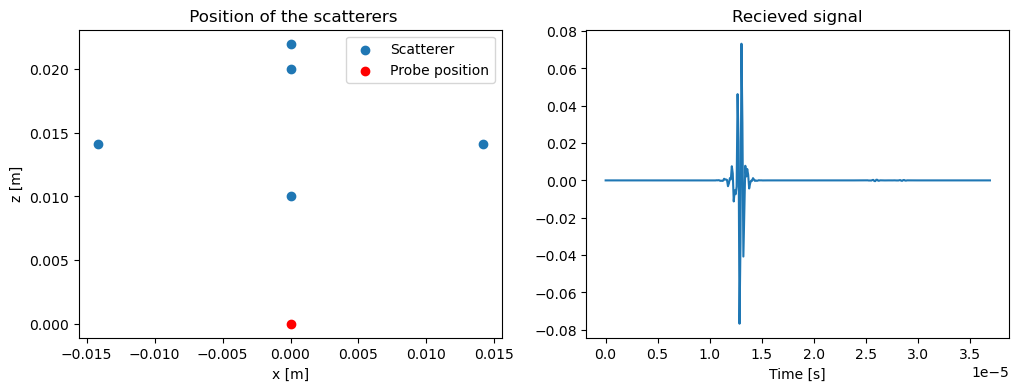

In [15]:
# Here is a plot
_, (f1, f2) = plt.subplots(ncols = 2, figsize = (12, 4))
plt.sca(f1)
plt.scatter(xScatterers, zScatterers, label = 'Scatterer')
plt.scatter([0], [0], c = 'r', label = 'Probe position') # The probe is located here
plt.title (' Position of the scatterers')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()

plt.sca(f2)
plt.plot(t, RF.flatten())
#plt.plot(t, np.abs(IQ).flatten())
plt.title('Recieved signal')
plt .xlabel('Time [s]')


### Exercise 1.4: Several scatterers

1. Run the previous code simulation, and visualise the radiofrequency plot. How many peaks do you observe, and at which time delay (approximately)? Why the number of peaks is not equal to the number of scatterers? 

1. Comment on the power of each received echo, based on the distance to the probe. Why does it happen? [Hint: remember that there is no attenuation, and the reemitted wave is spherical by Huygens principle]

1. Based on the delay from transmit to receive each peak, compute the distance of the scatterer to the probe. (Same as question 3 in Exercise 2) [You can use plt.axvline to draw a vertical line at an abcisse value, and use it to manually find out the position of the different peaks, or you can use scipy.signal.find_peaks]

1. Set the probe bandwidth to 10%. How many peaks can you observe now? Why?

## Part 5: I/Q Transform

For this, we will use demodulation, which is removing the high frequencies around the central frequency to obtain the envelope of the signal. This is done by multiplying the signal by a complex sinus with the same frequency as the central frequency of the signal. The resulting signal is a complex-valued signal called in-phase/quadrature (IQ), and is obtained using the function rf2iq. The original radiofrequency signal, and either the central frequency or the probe parameters need to be provided. In general, the IQ signal will allow an easier analysis of the signal, since it will be clearer to identify the maximum power.

In [ ]:
if True: # Single scatterer
    xScatterers = np.array([ 0])
    zScatterers = np.array([2e-2])
    RCScatterers = np.ones(1) # There are 5 scatterers
else: # 5 scatterers, for the second part of the exercise
    xScatterers = np.array([0, 0,np.sqrt(2)*1e-2, - np.sqrt(2)*1e-2,  0])
    zScatterers = np.array([1e-2, 2e-2, np.sqrt(2) * 1e-2, np.sqrt(2) * 1e-2, 2.2e-2])
    RCScatterers = np.ones(5) # There are 5 scatterers

#RCScatterers[1:] = 0
activationDelaysTX = np.array([0]).reshape(1,1)

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers, activationDelaysTX, param_single_element)
# TODO: use the pymust rf2iq function with the correct paramters
IQ =   #...
t = np.arange(RF.shape[0]) / param_single_element.fs # param_single_element.fs is the sampling frequency, needed to go from sample number to time


In [ ]:
_, fs = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10))

# RF/IQ time domain
plt.sca(fs[0, 0])
plt.plot(t, RF, label = 'RF')
plt.plot(t, np.abs(IQ), label = 'IQ')
plt.xlabel('Time [s]')
plt.ylabel('Power')
plt.legend()


# RF/IQ - Fourier
plt.sca(fs[1, 0])

freqs, RF_spectrum = #...  my_fft(RF.flatten(), 1/param_single_element.fs, False)
plt.plot(freqs, np.abs(RF_spectrum), label = 'RF spectrum')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')

plt.sca(fs[1, 1])

freqs, IQ_spectrum = #...  my_fft(IQ.flatten(), 1/param_single_element.fs, False)
plt.plot(freqs, np.abs(IQ_spectrum), label = 'IQ spectrum')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')


In [ ]:
# This code generates the IQ signal from the RF signal step by step, and is equivalent to pymust.rf2iq
#  you can ignore this code, but plot the individual stages to see the effect of each operation if you are curious
import scipy
Wn = min(2*param_single_element.fc/param_single_element.fs,0.5)
#%-- Down-mixing of the RF signals
IQ_1 = np.exp(-1j*2*np.pi*param_single_element.fc*t.reshape((-1,1)))*RF

# %-- Low-pass filter
b,a = scipy.signal.butter(5,Wn)
IQ_2 = scipy.signal.filtfilt(b,a,IQ, axis = 0)*2; #% factor 2: to preserve the envelope amplitude

### Exercise 1.5  I/Q transform

1. With a single scatterer and the original bandwidth, apply the nonreal Fourier transform (to obtain both positive and negative frequencies) to the original (RF) and demodulated (IQ) signals and obtain their frequency-domain representation. Plot both the positive and negative frequencies, and explain the effect of the I/Q transform on the spectral domain. [Note: it is possible to do this with several scatterers, but then the spectra will have some noise due to phase mismatch.]

1. Using the same 5 scatterers as in exercise 4, plot the original RF, and its IQ envelope (absolute value of the IQ signal). Comment the difficulty to visually identify the individual pulses in the I/Q and RF signals.

## Part 6: Attenuation

In [ ]:
# Copy here the multiview plot from Part 3, and add attenuation to the probe (param_single_element.attenuation = .5)

TypeError: cannot unpack non-iterable ellipsis object

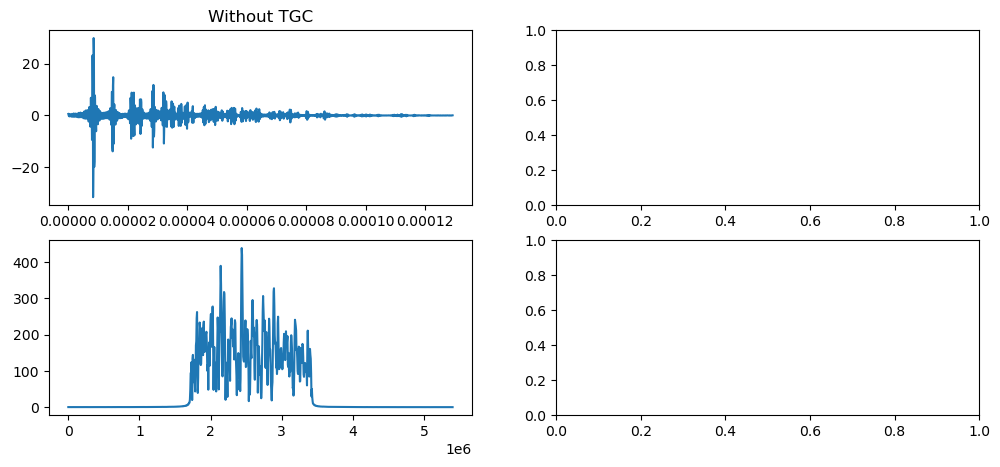

In [64]:
# TGC experiment. You need several scatters to work
param_single_element = getProbe()
param_single_element.attenuation = .5
activationDelaysTX = np.zeros(param_single_element.Nelements).reshape(1, -1)

N = 100
xScatterers = np.zeros(N)
#zScatterers = np.random.rand(N)*5e-2
zScatterers = np.linspace(1e-3, 5e-2, N) +np.random.rand(N)*5e-2

RCScatterers = np.random.rand(N) # There are 5 scatterers
RCScatterers = np.ones(N)
_, ((f1, f2), (f3, f4)) = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 5))
plt.sca(f1)
opt = pymust.utils.Options()
opt.dBThresh = -3
RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers, activationDelaysTX, param_single_element, opt)
t = np.arange(RF.shape[0]) / param_single_element.fs # param_single_element.fs is the sampling frequency, needed to go from sample number to time
plt.plot(t, RF)
plt.title('Without TGC')
plt.sca(f3)
f, RF_spectrum = my_fft(RF[:, 0], 1/param_single_element.fs)
plt.plot(f, np.abs(RF_spectrum))

RF_tgc, c = ... # Complete
plt.sca(f2)
plt.plot(t, RF_tgc)
plt.title('With TGC')
plt.sca(f4)
f, RF_tgc_spectrum = my_fft(RF_tgc[:, 0], 1/param_single_element.fs)
plt.plot(f, np.abs(RF_spectrum))


1. Add the attenuation, by setting the parameter "attenuation" of the param struct, and redo the figure of exercise 3. What do you observe in the spectra and time-domain?

1. Do the time-gain compensation function to the radiofrequencies (pymust.tgc, only use the first return parameter). What effect do you observe in the received intensity? and the spectrum?